In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
# change the path to current pwd
path = "/content/drive/My Drive/Colab Notebooks/RAE"

os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['shrink',
 'data',
 'AddNoise',
 'RAE.ipynb',
 'model',
 'ImShow.py',
 '__pycache__',
 'RAE_with_noise_improved.ipynb',
 'RAE_with_noise.ipynb',
 'RAE_with_noise_improved.ipynb（副本）',
 'RAE_l21_feature.ipynb',
 'RAE_l21_instance.ipynb']

# Load package

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F
from torch import nn, optim
import torch
from torch import optim
from torchvision import datasets, transforms

# use GPU for computation if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Import the model and methods that defined by us

In [ ]:
from AddNoise import addnoise
from model.DeepAutoencoder import DAE
from model.VAE import VAE
import ImShow as I
from shrink import l1shrink as SHR 
from model.train import train 

# Load the data and configure the model

In [ ]:
BATCH_SIZE = 100

LEARNING_RATE = 1e-3

EPOCH = 10

data = np.load('./data/data.npk', allow_pickle=True)
y = np.load("./data/y.npk", allow_pickle=True)
torch.tensor(data).shape

train_data = torch.tensor(data)
train_label = torch.tensor(y).view((5124,1))

## 1. Train Deep autoencoder model

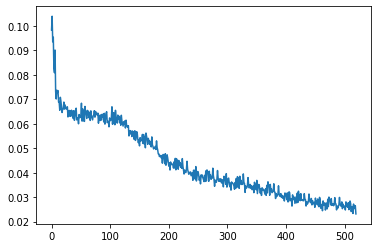

In [ ]:
model_DAE = DAE()
model_DAE.to(device)
optimizer = optim.Adam(model_DAE.parameters(), lr=LEARNING_RATE)

train_data_RED = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE, shuffle=False)
train(train_data_RED, model_DAE, optimizer)

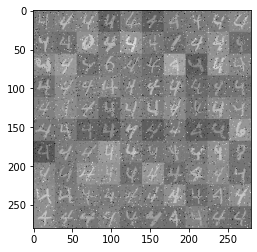

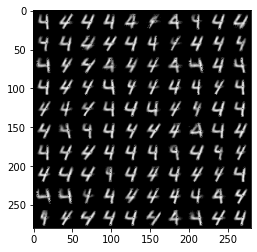

In [ ]:
with torch.no_grad():
  z = next(iter(train_data_RED))[:100]
  z = z.view(-1, 28*28)
  z = z.to(device)
  z_noise = addnoise.add_noise_uniform_normal(z,100)

  z_noise_np = z_noise.cpu().numpy()
  noise_image = I.tile_raster_images(z_noise_np,(28,28),(10,10))

  plt.imshow(noise_image,cmap='gray')
  plt.show()
  # plot_images(z_noise)
  plt.imshow(I.tile_raster_images(model_DAE(z_noise).cpu().numpy(), (28,28),(10,10)),cmap='gray')
  plt.show()

## 2. Train Variational autoencoder Model

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


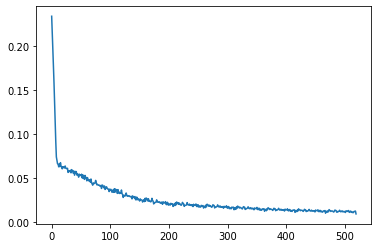

In [ ]:
model_VAE = VAE()
model_VAE.to(device)
optimizer = optim.Adam(model_VAE.parameters(), lr=LEARNING_RATE)

train_data_RED = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE, shuffle=False)
train(train_data_RED, model_VAE, optimizer)

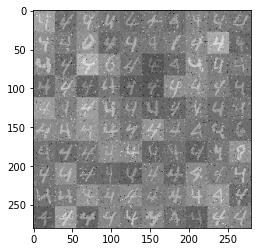

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


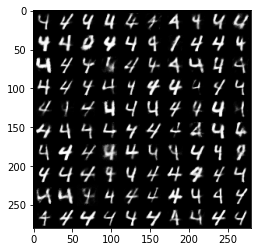

In [ ]:
with torch.no_grad():
  z = next(iter(train_data_RED))[:100]
  z = z.view(-1, 28*28)
  z = z.to(device)
  z_noise = addnoise.add_noise_uniform_normal(z,100)

  z_noise_np = z_noise.cpu().numpy()
  noise_image = I.tile_raster_images(z_noise_np,(28,28),(10,10))

  plt.imshow(noise_image,cmap='gray')
  plt.show()
  # plot_images(z_noise)
  plt.imshow(I.tile_raster_images(model_VAE(z_noise).cpu().numpy(), (28,28),(10,10)),cmap='gray')
  plt.show()


## 3. Train Robust Deep autoencoder

In [ ]:
class RDAE(object):
  def __init__(self, lambda_=1.0, error=1.0e-7):
    super(RDAE,self).__init__()
    self.lambda_ = lambda_
    self.error = error
    self.AE = DAE()

  def fit(self, X):
    self.AE.to(device)
    optimizer = optim.Adam(self.AE.parameters(), lr=LEARNING_RATE)
    error = self.error
    lambda_ = self.lambda_

    L = torch.zeros(X.shape)
    S = torch.zeros(X.shape)

    LS0 = L + S

    XFnorm = torch.norm(X, 'fro')
    mu = (len(X))/(4.0 * torch.norm(X, 1))

    # move to the device
    X = X.to(device)
    L = L.to(device)
    S = S.to(device)
    LS0 = LS0.to(device)

    # add noise to X
    # X = addnoise.add_noise_uniform_normal(X, 100)

    for i in range(5):
      # updata L
      L = X - S

      # generate train data
      train_datas = torch.utils.data.DataLoader(L, batch_size = BATCH_SIZE, shuffle=False)
      
      train(train_datas, self.AE, optimizer)
      
      with torch.no_grad():
        # get optimized L
        L = self.AE(L.float())
        
        # S = shrink_anomly(lambda_/mu, (X-L))
        S = SHR.shrink(lambda_/mu, (X-L))

      # break criterion 1: the L and S are close enough to X
        c1 = torch.norm(X-L-S, 'fro') / XFnorm

      # break criterion 2: there is no changes for L and S
        c2 = torch.min(mu, torch.sqrt(mu)) * torch.norm(LS0 - L - S) / XFnorm

        if c1 < error and c2 < error:
          print("early break")
          break
      LS0 = L + S
    return L, S

DAE(
  (enc1): Linear(in_features=784, out_features=625, bias=True)
  (enc2): Linear(in_features=625, out_features=400, bias=True)
  (enc3): Linear(in_features=400, out_features=225, bias=True)
  (enc4): Linear(in_features=225, out_features=100, bias=True)
  (dec1): Linear(in_features=100, out_features=255, bias=True)
  (dec2): Linear(in_features=255, out_features=400, bias=True)
  (dec3): Linear(in_features=400, out_features=625, bias=True)
  (dec4): Linear(in_features=625, out_features=784, bias=True)
  (criterion): MSELoss()
)


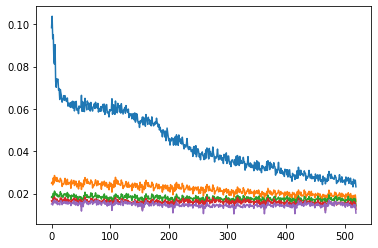

In [ ]:
model_RDAE = RDAE(lambda_= 1)
L, S = model_RDAE.fit(train_data)

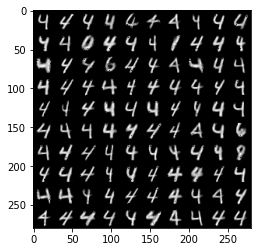

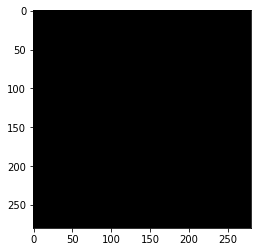

In [ ]:
L = L.cpu().numpy()
S = S.cpu().numpy()

L_pics = I.tile_raster_images(L, (28,28), (10,10))
S_pics = I.tile_raster_images(S, (28,28), (10,10))

plt.imshow(L_pics, cmap='gray')
plt.show()
plt.imshow(S_pics, cmap='gray')
plt.show()

# Denoising with 3 models

In [ ]:
def test_model(model, cor=100):
  z = next(iter(train_data_RED))[:100]
  z = z.view(-1, 28*28)
  z = z.to(device)
  z_noise = addnoise.add_noise_uniform_normal(z,cor)
  L = model(z_noise)
  S = z_noise - L

  z_noise = z_noise.cpu().numpy()
  L = L.cpu().numpy()
  S = S.cpu().numpy()

  z = I.tile_raster_images(z_noise, (28,28), (10,10))
  L_pics = I.tile_raster_images(L, (28,28), (10,10))
  S_pics = I.tile_raster_images(S, (28,28), (10,10))

  plt.imshow(z, cmap='gray')
  plt.title('Original')
  plt.show()
  plt.imshow(L_pics, cmap='gray')
  plt.title('Denoising')
  plt.show()
  plt.imshow(S_pics, cmap='gray')
  plt.title('Noise')
  plt.show()

250 noise points
RDAE


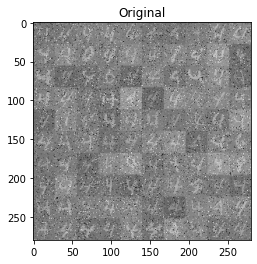

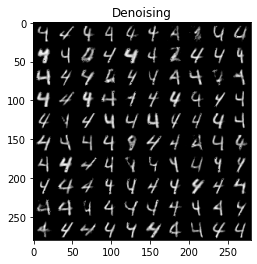

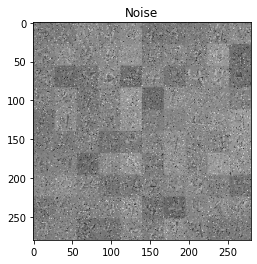

DAE


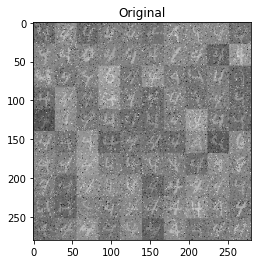

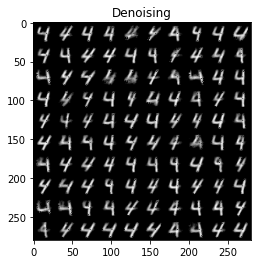

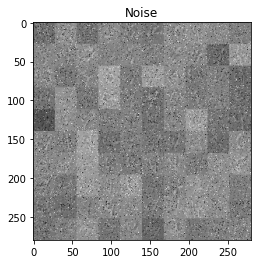

VAE


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


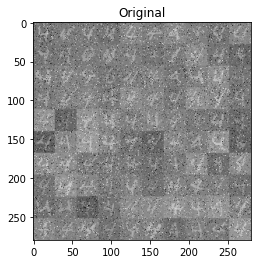

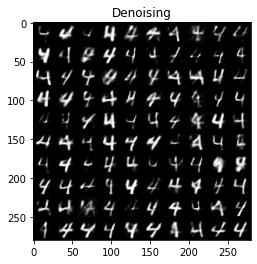

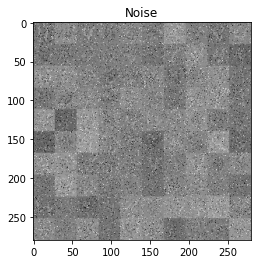

In [ ]:
print("250 noise points")
with torch.no_grad():
  print("RDAE")
  test_model(model_RDAE.AE, cor=250)
  print("DAE")
  test_model(model_DAE, cor=250)
  print("VAE")
  test_model(model_VAE, cor=250)

400 noise points
RDAE


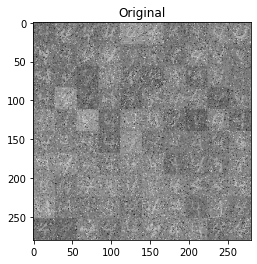

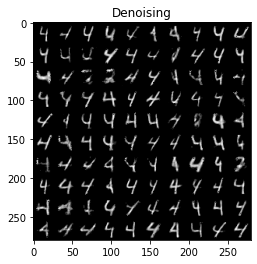

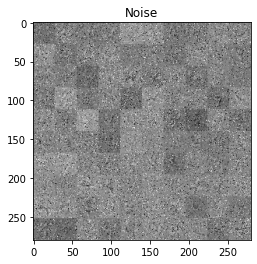

DAE


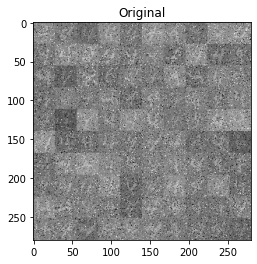

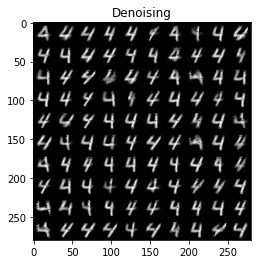

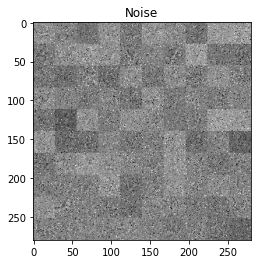

VAE


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


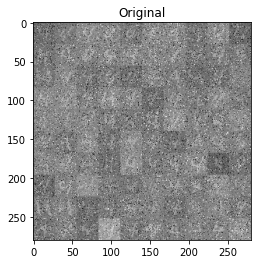

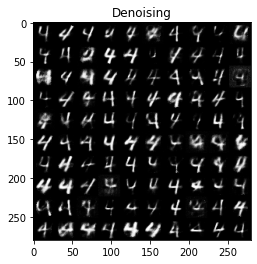

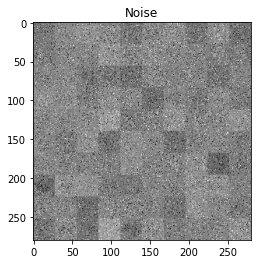

In [ ]:
print("400 noise points")
with torch.no_grad():
  print("RDAE")
  test_model(model_RDAE.AE, cor=400)
  print("DAE")
  test_model(model_DAE, cor=400)
  print("VAE")
  test_model(model_VAE, cor=400)

100 noise points
RDAE


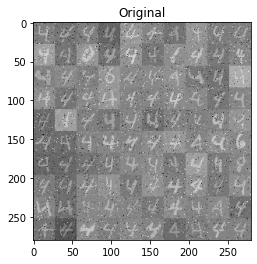

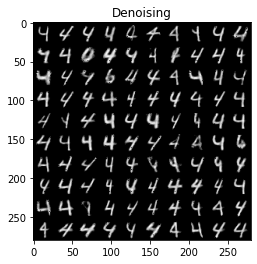

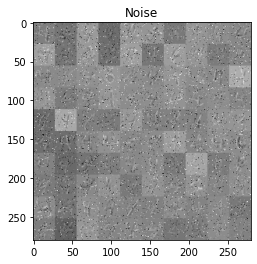

DAE


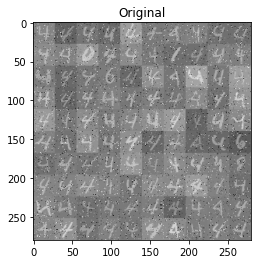

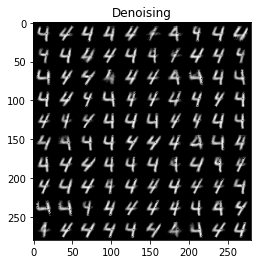

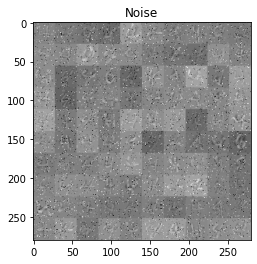

VAE


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


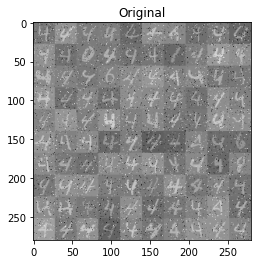

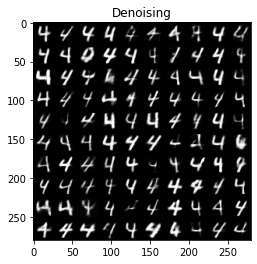

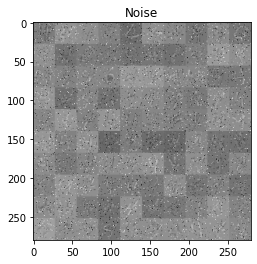

In [ ]:
print("100 noise points")
with torch.no_grad():
  print("RDAE")
  test_model(model_RDAE.AE, cor=100)
  print("DAE")
  test_model(model_DAE, cor=100)
  print("VAE")
  test_model(model_VAE, cor=100)

10 noise points
RDAE


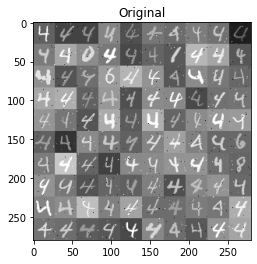

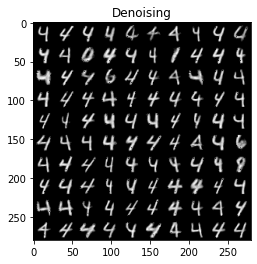

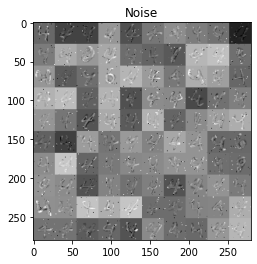

DAE


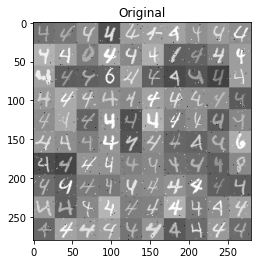

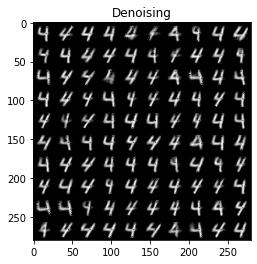

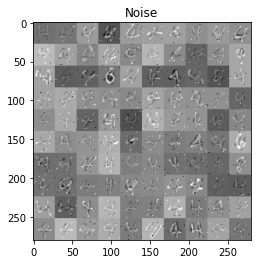

VAE


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


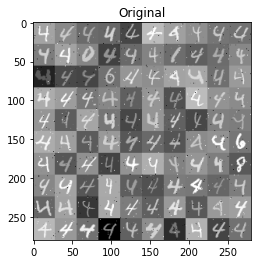

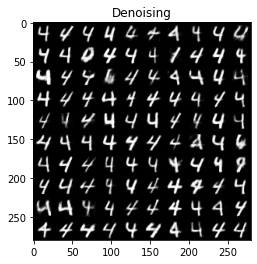

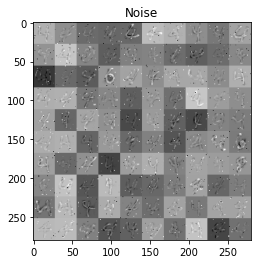

In [ ]:
print("10 noise points")
with torch.no_grad():
  print("RDAE")
  test_model(model_RDAE.AE, cor=10)
  print("DAE")
  test_model(model_DAE, cor=10)
  print("VAE")
  test_model(model_VAE, cor=10)